# Testbed to compare the results the parameter search
This bunches of code tests the differences between the window based on time and the window based on transfers. Once the link is defined, is possible to modify the parameters independently for different window selection and later to apply the EWMA to a set of the data. Later a plot is made to compare the results obtained by the to different window selection approach. 


In [1]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Some important functions

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

def get_link_data(src, dst, act, date='2017-08-01', span=1):
    es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
    DATE = date  # yyyy-mm-dd
    DELTA = span
    # Generate the indexes to scan
    dt.datetime.strptime(DATE,'%Y-%m-%d')
    index_list = []
    for i in range(-1, DELTA+1):
        index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                          + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
    #indexes = ','.join(index_list)
    indexes = 'fts_*'
    #print (index_list)
    period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
    period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=span)
    transfer_query = {
        "size": 0,
        "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
        'query':{
            "bool" : {
                "must" : [
                    {"term" : { "dst" : src }},
                    {"term" : { "src" : dst }},
                    {"term" : { "activity" : act }},
                    {"range" : {"transferred_at" : {  "gte": period_start } }},
                    {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                    ]
            }
        }

    }
    scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
    epoch = dt.datetime(1970,1,1)
    st = time.time()
    count = 0
    data = []
    for res in scroll:
        r = res['_source']
        #if not count%1000000 : print (count)
        r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
        data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
        count += 1
    #print('Reading took',time.time() - st,'seconds.')
    data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
    data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
    data['N_RATE'] = data.SIZE/(data['ENDED'] - data['STARTED'])
    data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
    print('%d records retrieved for link %s --> %s (%s).' % (len(data), src, dst, act))
    return data
def holt_winters_second_order_ewma( x, span, beta ):
    N = x.size
    alpha = 2.0 / ( 1 + span )
    s = np.zeros(( N, ))
    b = np.zeros(( N, ))
    s[0] = x[0]
    for i in range( 1, N ):
        s[i] = alpha * x[i] + ( 1 - alpha )*( s[i-1] + b[i-1] )
        b[i] = beta * ( s[i] - s[i-1] ) + ( 1 - beta ) * b[i-1]
    return s[-1],b[-1]
def hwsoewma_forcast(s0, b0, beta, span):
    '''Forcast span values after s0'''
    s = [s0]
    b = [b0]
    queue_limit_time = 7*24*60*60  # 7 days in sec.
    for i in range(1,span):
        s.append(min((s[i-1] + i*b[i-1]),queue_limit_time))
        b.append(beta*(s[i] - s[i-1])+(1-beta)*b[i-1])
    return (s,b)

def calculate_ewma(window=12, beta=0.1):
    preds = []
    for t in data.index:
        history = cut[cut.index < t]
        history = history[history.index > history.index.max() - dt.timedelta(hours=windows)]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s,b = hwsoewma_forcast(s0, b0, beta, 1)
            preds.append(max(s[0],-1))
        else:
            preds.append(-1)
    return preds


def make_prediction_time(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        subcut = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        subcut = subcut[subcut.index > current]
        fspan = len(subcut)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        history = history[history.index > history.index.max() - dt.timedelta(minutes=window)]
        if len(history) > 0:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(subcut))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(subcut))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]


def make_prediction_transfer(data, window, every, beta):
    cut1 = data.set_index(pd.to_datetime(data.SUBMITTED, unit='s'))
    cut1 = cut1.sort_index()
    cut2 = data.set_index(pd.to_datetime(data.ENDED, unit='s'))
    cut2 = cut2.sort_index()
    current = cut1.index.min()
    preds = []
    while current < cut1.index.max():
        s = cut1[cut1.index < current + dt.timedelta(minutes=every)]
        s = s[s.index > current]
        fspan = len(s)
        if fspan == 0:
            current = current + dt.timedelta(minutes=every)
            continue
        history = cut2[cut2.index < current]
        #history = history.set_index(pd.to_datetime(history.ENDED.values,unit='s'))
        #history = history.sort_index()
        history = history.loc[history.index[-window:]]
        if len(history) > 3:
            s0,b0 = holt_winters_second_order_ewma(history.Q_TIME.values, len(history.Q_TIME.values), beta)
            s1,b = hwsoewma_forcast(s0, b0, beta, len(s))
            preds.extend(s1)
        else:
            preds.extend([-1]*len(s))
        current = current + dt.timedelta(minutes=every)
    return cut1.SUBMITTED.values[:len(preds)],np.array(preds), cut1.Q_TIME.values[:len(preds)]

# Tests for the links
The optimal parameters for every link was calculated using this notebook

http://uct3-lx2.mwt2.org:9999/notebooks/jbogadog/EWMA%20(time%7Ctransfers%20base%20windows)%20to%20get%20max%20R2.ipynb

over the first 7 days of August. Is possible to change the time span modifying the 'days' parameter. If days = 31, all the transfers of August will be taken into account. 

The output for each test is:

number of records retrieved for link: BNL-ATLAS --> CERN-PROD (Data Consolidation).

MEAN queue time, STD queue time

dot plots and histogram of errors (pred1 is the prediction using window base on time, pred2 is the prediction unsing window base on number of transfers)

39466 records retrieved for link BNL-ATLAS --> CERN-PROD (Data Consolidation).
242.781903782 365.974345766


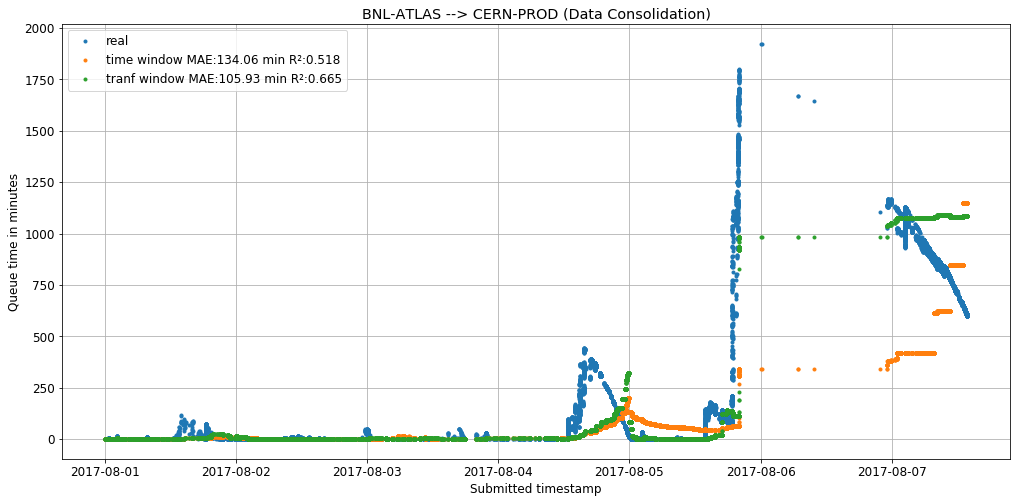

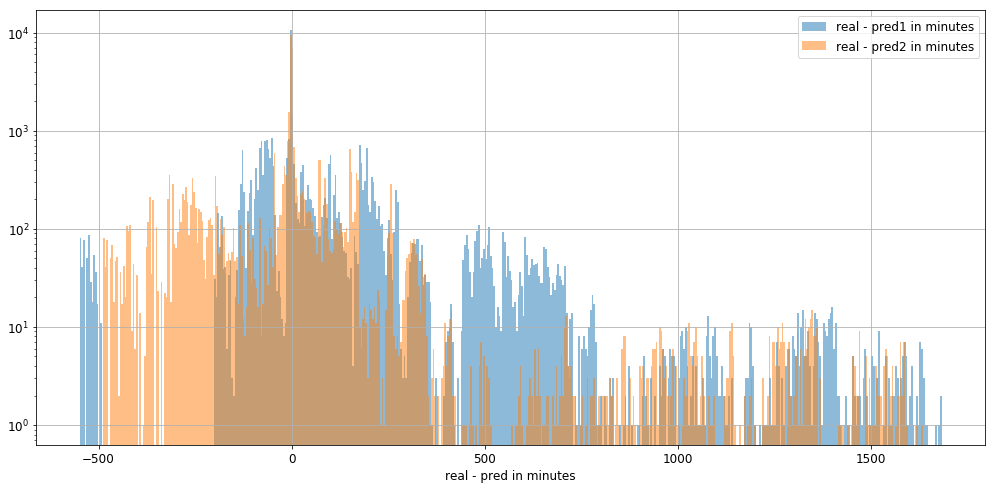

In [5]:
# link to test
src = 'BNL-ATLAS'
dst = 'CERN-PROD'
act = 'Data Consolidation'
# how many days look at
days = 7
# parameters for time based window
# window in minutes
window_1 = 2385
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 1000
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

27714 records retrieved for link BNL-ATLAS --> CERN-PROD (User Subscriptions).
742.214366902 686.558824309


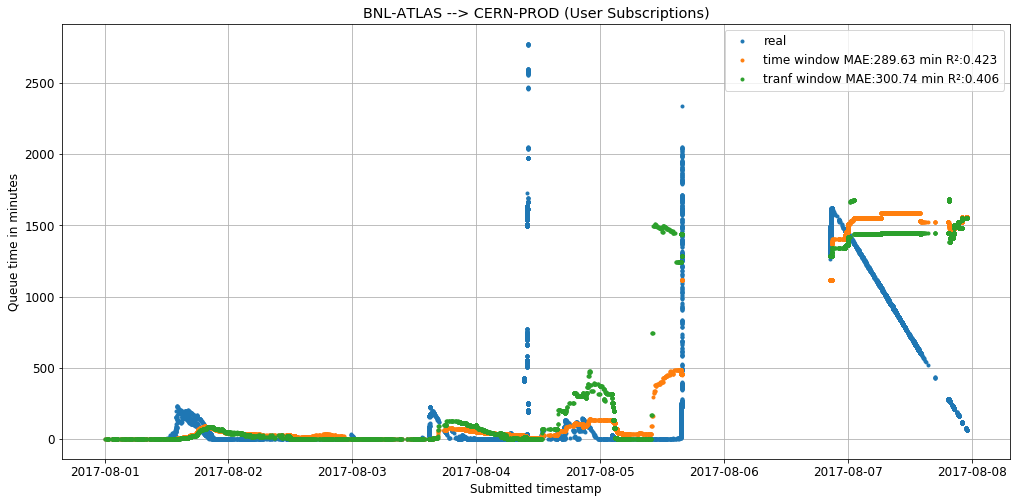

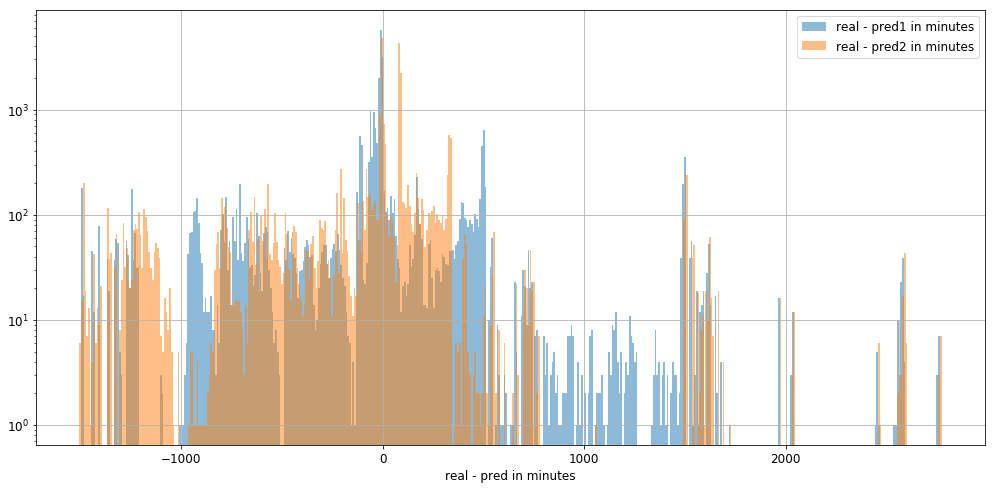

In [4]:
# link to test
src = 'BNL-ATLAS'
dst = 'CERN-PROD'
act = 'User Subscriptions'
days = 7
# parameters for time based window
# window in minutes
window_1 = 1529
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 575
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

In [ ]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Data Consolidation'
days = 7
# parameters for time based window
# window in minutes
window_1 = 75
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 952
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

15577 records retrieved for link CERN-PROD --> BNL-ATLAS (User Subscriptions).
872.951538974 830.686760573


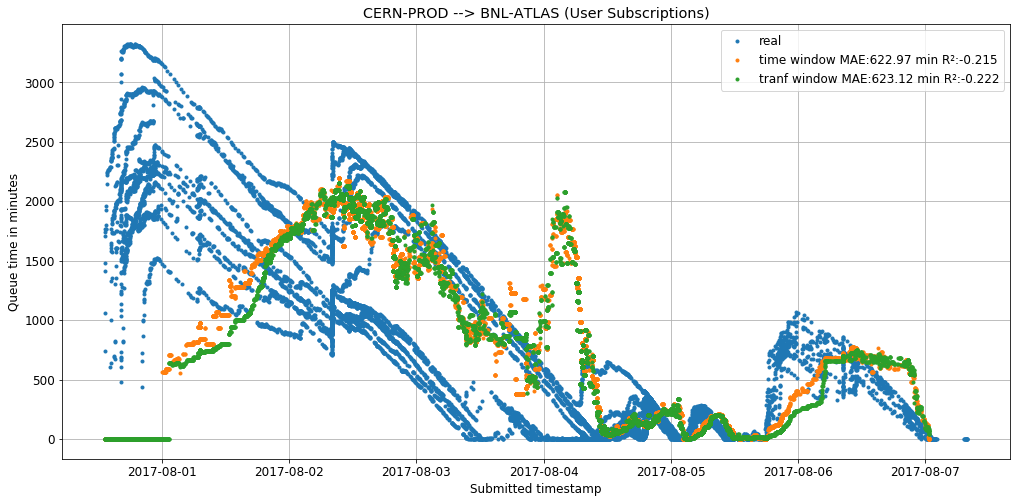

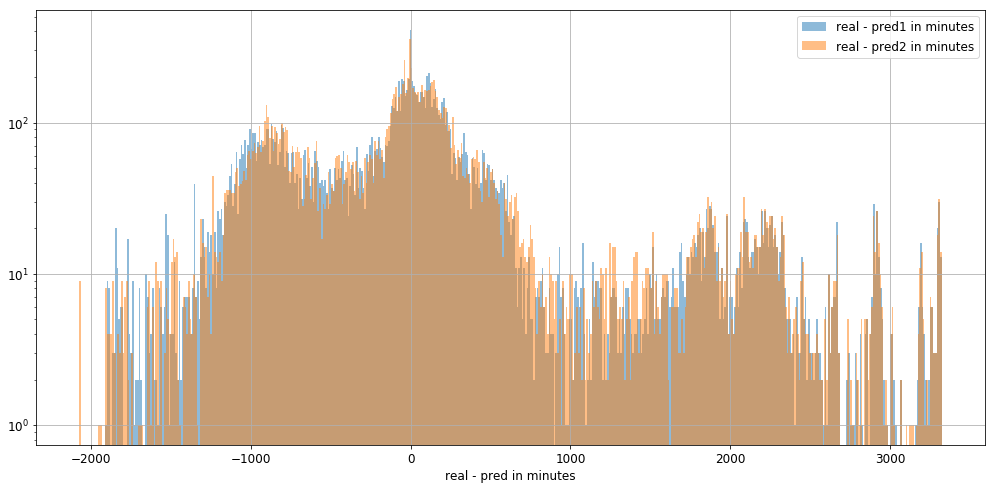

In [6]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'User Subscriptions'
days = 7
# parameters for time based window
# window in minutes
window_1 = 46
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

4508 records retrieved for link CERN-PROD --> BNL-ATLAS (Production Input).
81.4767474613 192.975601557


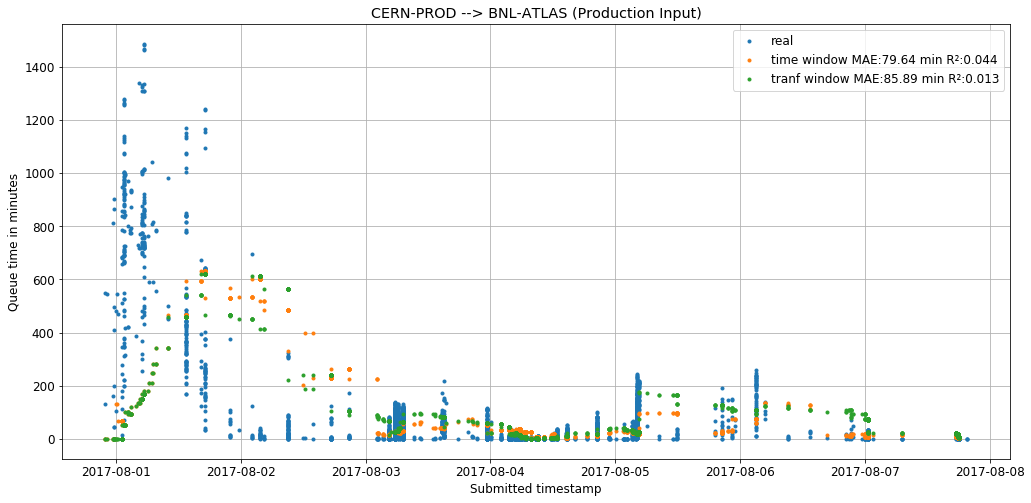

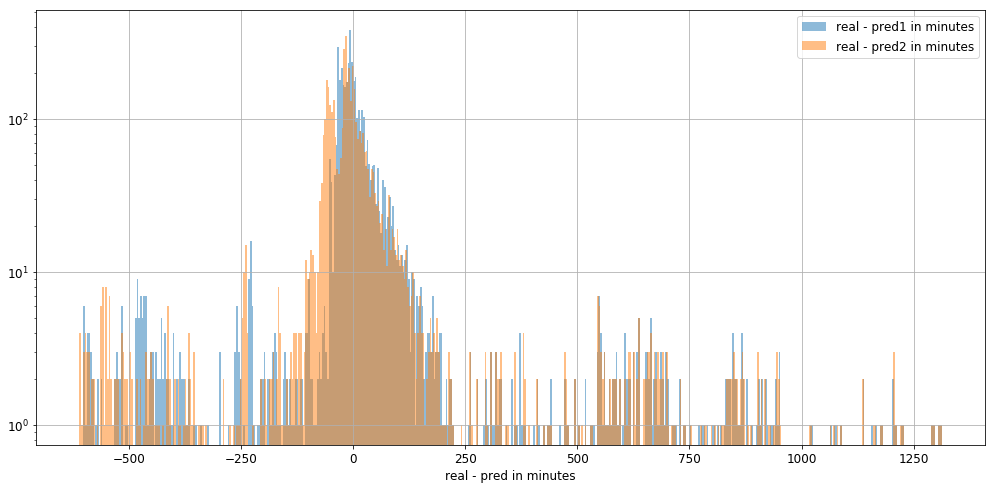

In [7]:
# link to test
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
days = 7
# parameters for time based window
# window in minutes
window_1 = 661
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()

fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

7380 records retrieved for link NDGF-T1 --> BNL-ATLAS (Production Input).
31.9580948506 54.9540076809


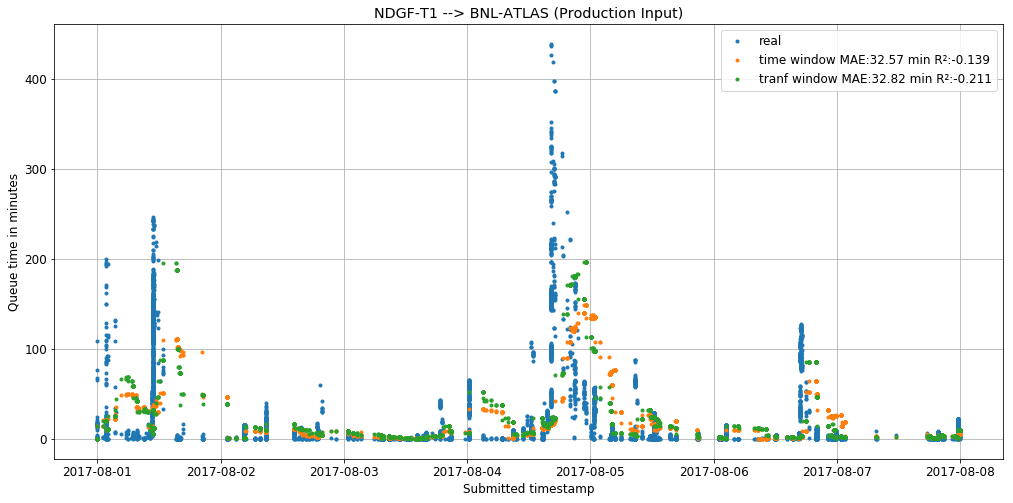

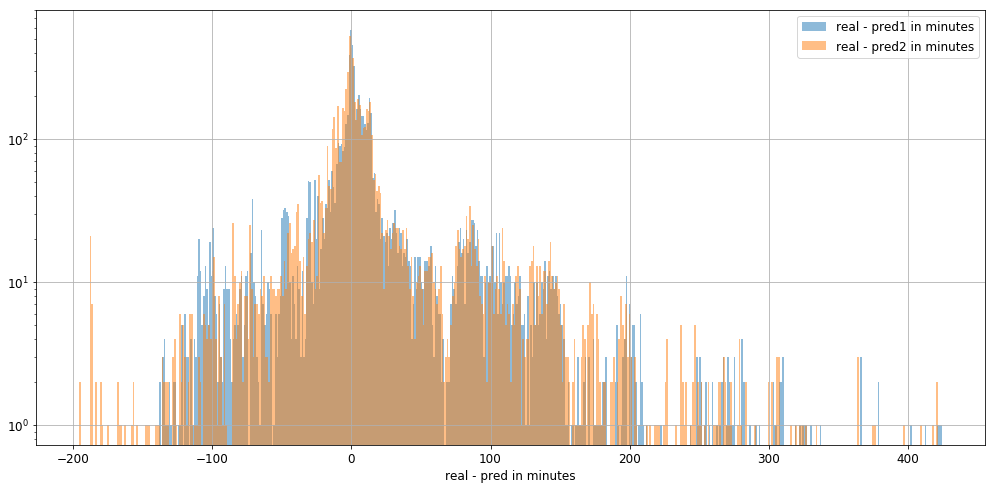

In [8]:
# link to test
src = 'NDGF-T1'
dst = 'BNL-ATLAS'
act = 'Production Input'
days = 7
# parameters for time based window
# window in minutes
window_1 = 358
# recalculate every x minutes
every_1 = 5
# the bigger the beta, the faster EWMA will react
beta_1 = 0.0000
# parameters for transfer based window
# number of transfers in the window
window_2 = 100
# recalculate every x minutes
every_2 = 5
beta_2 = 0.0000

data = get_link_data(src, dst, act,'2017-08-01', days)
x1,y1,y_real1 = make_prediction_time(data, window_1, every_1, beta_1)
x2,y2,y_real2 = make_prediction_transfer(data, window_2, every_2, beta_2)
print(np.mean(y_real1/60),np.std(y_real1/60))
plt.title('%s --> %s (%s)'% (src,dst,act))
plt.plot(pd.to_datetime(data.SUBMITTED.values,unit='s'),data.Q_TIME.values/60,'.', label='real')
plt.plot(pd.to_datetime(x1,unit='s'),y1/60,'.',
         label='time window MAE:%.2f min R²:%.3f'%(mae(y_real1,y1)/60,r2(y_real1,y1)))
plt.plot(pd.to_datetime(x2,unit='s'),y2/60,'.',
         label='tranf window MAE:%.2f min R²:%.3f'%(mae(y_real2,y2)/60,r2(y_real2,y2)))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Submitted timestamp')
plt.ylabel('Queue time in minutes')
fig = plt.gcf()

fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

plt.hist(y_real1/60 - y1/60, label='real - pred1 in minutes',bins=500, alpha=0.5)
plt.hist(y_real2/60 - y2/60, label='real - pred2 in minutes',bins=500, alpha=0.5)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('real - pred in minutes')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()